In [2]:
# !pip install gym
import gym
env = gym.make('CartPole-v0')

    100% |████████████████████████████████| 1.5MB 10.7MB/s 
    100% |████████████████████████████████| 1.0MB 12.9MB/s 
  Running setup.py bdist_wheel for gym ... - \ | / done
  Stored in directory: /content/.cache/pip/wheels/cb/14/71/f4ab006b1e6ff75c2b54985c2f98d0644fffe9c1dddc670925
Successfully built gym
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [3]:
import numpy as np
import random
import tensorflow as tf
tf.enable_eager_execution()

seed_val = 111
np.random.seed(seed_val)
random.seed(seed_val+1)
tf.set_random_seed(seed_val+2)
env.seed(seed_val+3)

[114]

In [4]:
from collections import deque
from keras.models import clone_model
# from keras.utils import to_categorical
from keras import optimizers

Using TensorFlow backend.


In [0]:
def preprocess(img):
    return np.reshape(img, (1,4))


In [0]:
class PolicyEstimator():
  """
  Policy Function Approximation
  """
  def __init__(self, learning_rate = 0.1):
    self.learning_rate = learning_rate
    self.pi = self._build_model()
    self.grad_init = [tf.zeros_like(theta) for theta in self.pi.get_weights()]
  
  def _build_model(self):
    model = tf.keras.Sequential([
#         tf.keras.layers.Dense(16, input_shape=(4,), activation='relu'),
#         tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(N_ACTIONS, input_shape=(4,), activation='linear', use_bias=True)
    ])
    self.optimizer = tf.train.GradientDescentOptimizer(learning_rate=self.learning_rate)
#     model.add()
#     model.add(Dense(32, activation='relu'))
#     model.add()
#     model.compile(optimizers.Adam(lr=self.learning_rate), loss='categorical_crossentropy')
    return model
  
  def logpi(self, states):
    predictions = self.pi(states)
    return tf.log(predictions)
  
  def select_action(self, state):
    prob_dist = tf.squeeze(tf.nn.softmax(pi_model.pi(state))).numpy()
    return np.random.choice([0,1], p=prob_dist)
#     return np.argmax(self.pi(cur_state))
  
  def loss(self, state, action, advantage):
    # negative loss because we're maximizing
    ## picking the log_probability corresponding to the action taken and
    ## scaling it by 'advantage'
    pi = tf.nn.softmax(self.pi(state))
    action_one_hot = np.zeros_like(pi)
    action_one_hot[0,action] = 1
#     loss_val = -tf.nn.l2_loss(pi - action_one_hot) * advantage
    return -tf.gather(tf.squeeze(tf.log(pi)), action)*advantage
#     return loss_val
  
  def compute_gradient(self, state, action, advantage):
    """
    Compute the gradient at time t
    :param state: the state for which pi will be calculated, shape 1 x |S|
    :param action: action taken. 
    :return list of Gradient tensors with length = count(weights)+ count(biases)
    """
    with tf.GradientTape() as tape:
      loss_val = self.loss(state, action, advantage)
    return tape.gradient(loss_val, self.pi.variables)
  
  def apply_gradient(self, grads):
    """"""
    self.optimizer.apply_gradients(zip(grads, self.pi.variables),
                                   global_step=tf.train.get_or_create_global_step())


pi_model = PolicyEstimator()

In [0]:
N_ACTIONS = env.action_space.n
DIM_STATES = env.observation_space.shape[0]
N_EPISODES = 100
BATCH_SIZE = 50
TIMESTEP_LIMIT = env.spec.timestep_limit
discount_factor = 0.99

In [8]:
pi_model = PolicyEstimator()
avg_rewards = []
for episode in range(1,N_EPISODES+1):
  
  episode_rewards = []
  # copy zero initialized list by value
  grad = pi_model.grad_init[:]
  all_returns = np.zeros((BATCH_SIZE, TIMESTEP_LIMIT))
  rewards = [[] for _ in range(BATCH_SIZE)]
  states = [[] for _ in range(BATCH_SIZE)]
  actions = [[] for _ in range(BATCH_SIZE)]
  
  for roll_i in range(BATCH_SIZE):
    done = False
    cur_state = preprocess(env.reset())
    for t in range(TIMESTEP_LIMIT):
      action = pi_model.select_action(cur_state)
      next_state, reward, done, info = env.step(action)
      next_state = preprocess(next_state)
      states[roll_i].append(cur_state)
      actions[roll_i].append(action)
      rewards[roll_i].append(reward)
      cur_state = next_state
      if done:
        episode_rewards.append(np.sum(rewards[roll_i]))
        for t_ in range(len(rewards[roll_i])):
          all_returns[roll_i,t_] = sum([discount_factor**ix * reward for ix, reward in enumerate(rewards[roll_i][t_:])])
        break
      
  baselines = np.mean(all_returns, axis=0)
  advantages = all_returns - baselines
  for roll_i in range(BATCH_SIZE):
    for t in range(len(states[roll_i])):
#       pi_model.optimizer.minimize(loss=lambda: pi_model.loss(states[roll_i][t], actions[roll_i][t], advantages[roll_i,t]),
#                                   global_step=tf.train.get_or_create_global_step())
      grad_t = pi_model.compute_gradient(states[roll_i][t], actions[roll_i][t], advantages[roll_i][t])
      # grad_t is a list of weights and biases, so do element-wise summation
      grad = [grad[i] + grad_t[i] for i in range(len(grad))]
  
  grad = [g_i/(np.linalg.norm(g_i)+1e-8) for g_i in grad]
  pi_model.apply_gradient(grad)  
  
  avg_rewards.append(np.mean(episode_rewards))
  if episode%1 == 0: print("Episode:{}, Avg Rewards:{}, Norm of Weights:{}".format(episode,
                                                                                   avg_rewards[-1],
                                                                                   np.linalg.norm(pi_model.pi.get_weights()[0])))

Episode:1, Avg Rewards:20.78, Norm of Weights:1.5236045122146606
Episode:2, Avg Rewards:23.74, Norm of Weights:1.5349736213684082
Episode:3, Avg Rewards:25.7, Norm of Weights:1.5531269311904907
Episode:4, Avg Rewards:27.64, Norm of Weights:1.5688601732254028
Episode:5, Avg Rewards:29.24, Norm of Weights:1.5971754789352417
Episode:6, Avg Rewards:28.58, Norm of Weights:1.62785804271698
Episode:7, Avg Rewards:34.8, Norm of Weights:1.6678096055984497
Episode:8, Avg Rewards:37.1, Norm of Weights:1.7015941143035889
Episode:9, Avg Rewards:38.1, Norm of Weights:1.7438633441925049
Episode:10, Avg Rewards:43.76, Norm of Weights:1.785717487335205
Episode:11, Avg Rewards:43.84, Norm of Weights:1.834344506263733
Episode:12, Avg Rewards:50.02, Norm of Weights:1.8535699844360352
Episode:13, Avg Rewards:51.96, Norm of Weights:1.904306173324585
Episode:14, Avg Rewards:50.62, Norm of Weights:1.9506417512893677
Episode:15, Avg Rewards:57.02, Norm of Weights:2.000485897064209
Episode:16, Avg Rewards:54.16

Episode:55, Avg Rewards:180.68, Norm of Weights:3.911524772644043
Episode:56, Avg Rewards:168.04, Norm of Weights:3.940871238708496
Episode:57, Avg Rewards:185.26, Norm of Weights:3.9953434467315674
Episode:58, Avg Rewards:180.06, Norm of Weights:4.038073539733887
Episode:59, Avg Rewards:181.44, Norm of Weights:4.076930999755859
Episode:60, Avg Rewards:188.24, Norm of Weights:4.1455183029174805
Episode:61, Avg Rewards:196.16, Norm of Weights:4.158299446105957
Episode:62, Avg Rewards:184.02, Norm of Weights:4.214580535888672
Episode:63, Avg Rewards:188.6, Norm of Weights:4.232759475708008
Episode:64, Avg Rewards:187.72, Norm of Weights:4.241074562072754
Episode:65, Avg Rewards:194.2, Norm of Weights:4.266402721405029
Episode:66, Avg Rewards:185.5, Norm of Weights:4.285506248474121
Episode:67, Avg Rewards:191.34, Norm of Weights:4.308255195617676
Episode:68, Avg Rewards:185.78, Norm of Weights:4.390329360961914
Episode:69, Avg Rewards:194.48, Norm of Weights:4.398716449737549
Episode:70,

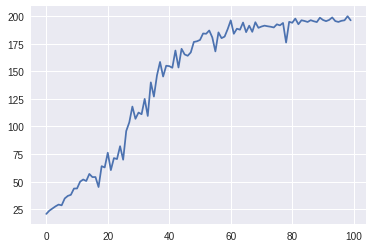

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(avg_rewards)
